# Phase 3: Model Development
## Install Required Packages

**Important:** Run the next cell first to install TensorFlow and other dependencies in your notebook's environment.

---
## Setup and Imports

In [1]:
# Install TensorFlow (run the install cell at the top if needed)

# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Deep Learning
import tensorflow as tf  # type: ignore
from tensorflow.keras import layers, models, callbacks  # type: ignore
from tensorflow.keras.optimizers import Adam  # type: ignore

# Scikit-learn
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (mean_squared_error, r2_score, mean_absolute_error, 
                             mean_absolute_percentage_error, accuracy_score, 
                             precision_score, recall_score, f1_score, 
                             confusion_matrix, classification_report)

# Display settings
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

print("✓ All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
gpus = tf.config.list_physical_devices('GPU')
print(f"GPU available: {len(gpus) > 0} - {gpus}")

✓ All libraries imported successfully!
TensorFlow version: 2.20.0
GPU available: False - []


---
## Load Processed Data

In [2]:
# Define paths
data_path = Path('project_data')
splits_path = data_path / 'train_test_split'

print("Loading train/validation/test splits...")
print("="*80)

Loading train/validation/test splits...


In [3]:
# Function to categorize yields
def categorize_yield(yields, percentiles=None):
    """
    Categorize continuous yield values into Low/Medium/High classes
    """
    if percentiles is None:
        percentiles = [np.percentile(yields, 33.33), np.percentile(yields, 66.67)]
    
    categories = np.zeros(len(yields), dtype=int)
    categories[yields < percentiles[0]] = 0  # Low
    categories[(yields >= percentiles[0]) & (yields < percentiles[1])] = 1  # Medium
    categories[yields >= percentiles[1]] = 2  # High
    
    return categories, percentiles

print("✓ Yield categorization function defined")
print("Categories: 0=Low, 1=Medium, 2=High")

✓ Yield categorization function defined
Categories: 0=Low, 1=Medium, 2=High


### Define Yield Categories

We'll classify yields into three categories for classification metrics:
- **Low**: Below 33rd percentile
- **Medium**: Between 33rd and 67th percentile  
- **High**: Above 67th percentile

---
## Part 1: FNN (Feedforward Neural Network) Model

### 1.1 Load FNN Data

In [4]:
print("\n📊 LOADING FNN DATA...")

# Load splits
fnn_train = pd.read_csv(splits_path / 'fnn' / 'train.csv')
fnn_val = pd.read_csv(splits_path / 'fnn' / 'val.csv')
fnn_test = pd.read_csv(splits_path / 'fnn' / 'test.csv')

print(f"  Train: {fnn_train.shape}")
print(f"  Val:   {fnn_val.shape}")
print(f"  Test:  {fnn_test.shape}")

# Remove rows with missing yields
fnn_train = fnn_train.dropna(subset=['Yield_tonnes_per_ha'])
fnn_val = fnn_val.dropna(subset=['Yield_tonnes_per_ha'])
fnn_test = fnn_test.dropna(subset=['Yield_tonnes_per_ha'])

print(f"\nAfter removing missing yields:")
print(f"  Train: {fnn_train.shape}")
print(f"  Val:   {fnn_val.shape}")
print(f"  Test:  {fnn_test.shape}")


📊 LOADING FNN DATA...
  Train: (2916, 33)
  Val:   (324, 33)
  Test:  (432, 33)

After removing missing yields:
  Train: (2916, 33)
  Val:   (324, 33)
  Test:  (432, 33)


### 1.2 Prepare FNN Features

In [5]:
# Define feature columns for FNN
fnn_feature_cols = [
    # Climate features (growing season aggregates)
    'Avg_Temp_C', 'Min_Temp_C', 'Max_Temp_C', 'Temp_Range_C',
    'Rainfall_mm', 'Rainy_Days', 'Max_Daily_Rainfall_mm', 'Rainfall_Intensity',
    'Avg_Humidity_Percent', 'Min_Humidity_Percent', 'Max_Humidity_Percent',
    'CO2_ppm', 'CO2_Growth_Rate_ppm_per_year',
    
    # Stress indicators
    'Heat_Stress_Days', 'Cold_Stress_Days', 'Drought_Index', 'Flood_Risk_Index',
    
    # Soil properties
    'Soil_pH', 'Organic_Matter_Percent', 'Nitrogen_ppm', 'Phosphorus_ppm', 
    'Potassium_ppm', 'Cation_Exchange_Capacity', 'Bulk_Density', 
    'Water_Holding_Capacity_Percent'
]

target_col = 'Yield_tonnes_per_ha'

# Encode categorical variables
le_crop = LabelEncoder()
le_zone = LabelEncoder()
le_state = LabelEncoder()

# Fit on train, transform all
fnn_train['Crop_encoded'] = le_crop.fit_transform(fnn_train['Crop'])
fnn_val['Crop_encoded'] = le_crop.transform(fnn_val['Crop'])
fnn_test['Crop_encoded'] = le_crop.transform(fnn_test['Crop'])

fnn_train['Zone_encoded'] = le_zone.fit_transform(fnn_train['Geopolitical_Zone'])
fnn_val['Zone_encoded'] = le_zone.transform(fnn_val['Geopolitical_Zone'])
fnn_test['Zone_encoded'] = le_zone.transform(fnn_test['Geopolitical_Zone'])

fnn_train['State_encoded'] = le_state.fit_transform(fnn_train['State'])
fnn_val['State_encoded'] = le_state.transform(fnn_val['State'])
fnn_test['State_encoded'] = le_state.transform(fnn_test['State'])

# Add encoded features
fnn_feature_cols.extend(['Crop_encoded', 'Zone_encoded', 'State_encoded'])

print(f"\nTotal FNN features: {len(fnn_feature_cols)}")
print(f"Feature columns: {fnn_feature_cols}")


Total FNN features: 28
Feature columns: ['Avg_Temp_C', 'Min_Temp_C', 'Max_Temp_C', 'Temp_Range_C', 'Rainfall_mm', 'Rainy_Days', 'Max_Daily_Rainfall_mm', 'Rainfall_Intensity', 'Avg_Humidity_Percent', 'Min_Humidity_Percent', 'Max_Humidity_Percent', 'CO2_ppm', 'CO2_Growth_Rate_ppm_per_year', 'Heat_Stress_Days', 'Cold_Stress_Days', 'Drought_Index', 'Flood_Risk_Index', 'Soil_pH', 'Organic_Matter_Percent', 'Nitrogen_ppm', 'Phosphorus_ppm', 'Potassium_ppm', 'Cation_Exchange_Capacity', 'Bulk_Density', 'Water_Holding_Capacity_Percent', 'Crop_encoded', 'Zone_encoded', 'State_encoded']


In [6]:
# Prepare X and y
X_fnn_train = fnn_train[fnn_feature_cols].values
y_fnn_train = fnn_train[target_col].values

X_fnn_val = fnn_val[fnn_feature_cols].values
y_fnn_val = fnn_val[target_col].values

X_fnn_test = fnn_test[fnn_feature_cols].values
y_fnn_test = fnn_test[target_col].values

print(f"\nFNN arrays:")
print(f"  X_train: {X_fnn_train.shape}, y_train: {y_fnn_train.shape}")
print(f"  X_val:   {X_fnn_val.shape}, y_val:   {y_fnn_val.shape}")
print(f"  X_test:  {X_fnn_test.shape}, y_test:  {y_fnn_test.shape}")


FNN arrays:
  X_train: (2916, 28), y_train: (2916,)
  X_val:   (324, 28), y_val:   (324,)
  X_test:  (432, 28), y_test:  (432,)


In [7]:
# Scale features
fnn_scaler = StandardScaler()
X_fnn_train_scaled = fnn_scaler.fit_transform(X_fnn_train)
X_fnn_val_scaled = fnn_scaler.transform(X_fnn_val)
X_fnn_test_scaled = fnn_scaler.transform(X_fnn_test)

print("\n✓ Features scaled using StandardScaler")


✓ Features scaled using StandardScaler


### 1.3 Build FNN Model

In [8]:
def build_fnn_model(input_dim, learning_rate=0.001):
    """
    Build Feedforward Neural Network for crop yield prediction
    """
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        
        # Hidden layer 1
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        
        # Hidden layer 2
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.2),
        
        # Hidden layer 3
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.1),
        
        # Output layer
        layers.Dense(1, activation='linear')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )
    
    return model

# Build model
fnn_model = build_fnn_model(input_dim=X_fnn_train_scaled.shape[1])
fnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,977 (58.50 KB)

 Trainable params: 14,529 (56.75 KB)

 Non-trainable params: 448 (1.75 KB)

### 1.4 Train FNN Model

In [9]:
# Define callbacks
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-6,
    verbose=1
)

# Train model
print("\nTraining FNN model...")
history_fnn = fnn_model.fit(
    X_fnn_train_scaled, y_fnn_train,
    validation_data=(X_fnn_val_scaled, y_fnn_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

print("\n✓ FNN model training complete!")


Training FNN model...
Epoch 1/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 35.4192 - mae: 4.1200 - rmse: 5.9514 - val_loss: 21.8164 - val_mae: 3.1259 - val_rmse: 4.6708 - learning_rate: 0.0010
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 29.8216 - mae: 3.6260 - rmse: 5.4609 - val_loss: 17.3827 - val_mae: 2.6125 - val_rmse: 4.1693 - learning_rate: 0.0010
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24.0740 - mae: 3.3879 - rmse: 4.9065 - val_loss: 13.5113 - val_mae: 2.7571 - val_rmse: 3.6758 - learning_rate: 0.0010
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 20.9734 - mae: 3.5472 - rmse: 4.5797 - val_loss: 12.1477 - val_mae: 3.0539 - val_rmse: 3.4854 - learning_rate: 0.0010
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.5050 - mae: 3.7237 - rmse: 4.4165 - val_loss: 12.1413 - val_mae: 3.2642 - val_rmse: 3.4844 - learning_rate: 0.0010
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 19.0501 - mae: 3.8238 - rmse: 4.

### 1.5 Evaluate FNN Model

In [10]:
# Make predictions
y_fnn_pred_train = fnn_model.predict(X_fnn_train_scaled).flatten()
y_fnn_pred_val = fnn_model.predict(X_fnn_val_scaled).flatten()
y_fnn_pred_test = fnn_model.predict(X_fnn_test_scaled).flatten()

# Calculate regression metrics
def calculate_metrics(y_true, y_pred, set_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    print(f"\n{set_name} Set - Regression Performance:")
    print(f"  RMSE:  {rmse:.4f} tonnes/ha")
    print(f"  MAE:   {mae:.4f} tonnes/ha")
    print(f"  R²:    {r2:.4f}")
    print(f"  MAPE:  {mape:.2f}%")
    
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2, 'MAPE': mape}

# Calculate classification metrics
def calculate_classification_metrics(y_true, y_pred, set_name, percentiles=None):
    """
    Convert continuous predictions to categories and calculate classification metrics
    """
    # Categorize true and predicted values
    y_true_cat, percentiles = categorize_yield(y_true, percentiles)
    y_pred_cat, _ = categorize_yield(y_pred, percentiles)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true_cat, y_pred_cat)
    precision = precision_score(y_true_cat, y_pred_cat, average='weighted', zero_division=0)
    recall = recall_score(y_true_cat, y_pred_cat, average='weighted', zero_division=0)
    f1 = f1_score(y_true_cat, y_pred_cat, average='weighted', zero_division=0)
    
    print(f"\n{set_name} Set - Classification Performance:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    
    return {
        'Accuracy': accuracy, 
        'Precision': precision, 
        'Recall': recall, 
        'F1': f1,
        'y_true_cat': y_true_cat,
        'y_pred_cat': y_pred_cat,
        'percentiles': percentiles
    }

print("\n" + "="*80)
print("FNN MODEL EVALUATION")
print("="*80)

fnn_metrics_train = calculate_metrics(y_fnn_train, y_fnn_pred_train, "Train")
fnn_metrics_val = calculate_metrics(y_fnn_val, y_fnn_pred_val, "Validation")
fnn_metrics_test = calculate_metrics(y_fnn_test, y_fnn_pred_test, "Test")

# Calculate percentiles from training data (for consistent categorization)
_, fnn_percentiles = categorize_yield(y_fnn_train)

fnn_class_train = calculate_classification_metrics(y_fnn_train, y_fnn_pred_train, "Train", fnn_percentiles)
fnn_class_val = calculate_classification_metrics(y_fnn_val, y_fnn_pred_val, "Validation", fnn_percentiles)
fnn_class_test = calculate_classification_metrics(y_fnn_test, y_fnn_pred_test, "Test", fnn_percentiles)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

FNN MODEL EVALUATION

Train Set - Regression Performance:
  RMSE:  4.2891 tonnes/ha
  MAE:   3.7627 tonnes/ha
  R²:    -0.0137
  MAPE:  151.87%

Validation Set - Regression Performance:
  RMSE:  3.4709 tonnes/ha
  MAE:   3.1454 tonnes/ha
  R²:    -0.0002
  MAPE:  135.90%

Test Set - Regression Performance:
  RMSE:  2.7321 tonnes/ha
  MAE:   2.5997 tonnes/ha
  R²:    -0.0298
  MAPE:  134.13%

Train Set - Classification Performance:
  Accuracy:  0.3333
  Precision: 0.1111
  Recall:    0.3333
  F1-Score:  0.1667

Validation Set - Classification Performance:
  Accuracy:  0.3333
  Precision: 0.1111
  Recall:    0.3333
  F1-Score:  0.1667

Test Set - Classification Performance:
  Accuracy:  0.3333
  Precision: 0.1111
  Recall:    0.3333
  F1-Score:  0.1667


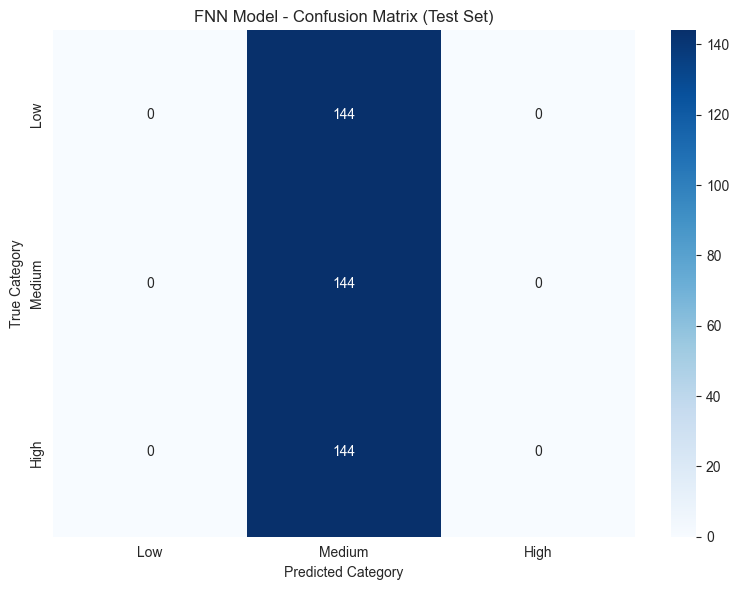


Detailed Classification Report (Test Set):
              precision    recall  f1-score   support

         Low       0.00      0.00      0.00       144
      Medium       0.33      1.00      0.50       144
        High       0.00      0.00      0.00       144

    accuracy                           0.33       432
   macro avg       0.11      0.33      0.17       432
weighted avg       0.11      0.33      0.17       432



In [11]:
# Confusion Matrix for FNN
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
cm = confusion_matrix(fnn_class_test['y_true_cat'], fnn_class_test['y_pred_cat'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
ax.set_xlabel('Predicted Category')
ax.set_ylabel('True Category')
ax.set_title('FNN Model - Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

print("\nDetailed Classification Report (Test Set):")
print(classification_report(fnn_class_test['y_true_cat'], fnn_class_test['y_pred_cat'],
                          target_names=['Low', 'Medium', 'High'], zero_division=0))

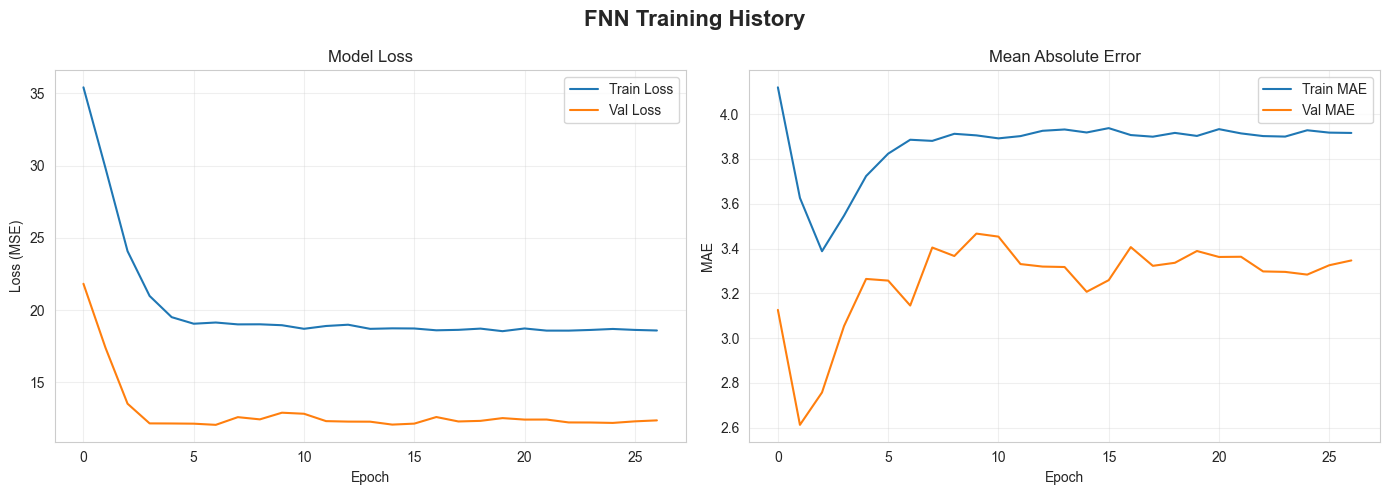

In [12]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('FNN Training History', fontsize=16, fontweight='bold')

# Loss
axes[0].plot(history_fnn.history['loss'], label='Train Loss')
axes[0].plot(history_fnn.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Model Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history_fnn.history['mae'], label='Train MAE')
axes[1].plot(history_fnn.history['val_mae'], label='Val MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Mean Absolute Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Part 2: LSTM (Long Short-Term Memory) Model

### 2.1 Load LSTM Data

In [13]:
print("\n📊 LOADING LSTM DATA...")

# Load splits
lstm_train = pd.read_csv(splits_path / 'lstm' / 'train.csv')
lstm_val = pd.read_csv(splits_path / 'lstm' / 'val.csv')
lstm_test = pd.read_csv(splits_path / 'lstm' / 'test.csv')

print(f"  Train: {lstm_train.shape}")
print(f"  Val:   {lstm_val.shape}")
print(f"  Test:  {lstm_test.shape}")

# Remove rows with missing yields
lstm_train = lstm_train.dropna(subset=['Yield_tonnes_per_ha'])
lstm_val = lstm_val.dropna(subset=['Yield_tonnes_per_ha'])
lstm_test = lstm_test.dropna(subset=['Yield_tonnes_per_ha'])

print(f"\nAfter removing missing yields:")
print(f"  Train: {lstm_train.shape}")
print(f"  Val:   {lstm_val.shape}")
print(f"  Test:  {lstm_test.shape}")


📊 LOADING LSTM DATA...
  Train: (34992, 38)
  Val:   (3888, 38)
  Test:  (5184, 38)

After removing missing yields:
  Train: (34992, 38)
  Val:   (3888, 38)
  Test:  (5184, 38)


### 2.2 Prepare LSTM Sequences

In [14]:
# Define LSTM feature columns (temporal features only)
lstm_feature_cols = [
    'Avg_Temp_C', 'Min_Temp_C', 'Max_Temp_C',
    'Rainfall_mm', 'Rainy_Days', 'Rainfall_Intensity',
    'Avg_Humidity_Percent',
    'CO2_ppm',
    'Heat_Stress_Days', 'Drought_Index', 'Flood_Risk_Index',
    'Is_Growing_Season'
]

# Add static features as encodings
lstm_train['Crop_encoded'] = le_crop.transform(lstm_train['Crop'])
lstm_val['Crop_encoded'] = le_crop.transform(lstm_val['Crop'])
lstm_test['Crop_encoded'] = le_crop.transform(lstm_test['Crop'])

lstm_feature_cols.append('Crop_encoded')

print(f"\nLSTM features: {len(lstm_feature_cols)}")
print(f"Feature columns: {lstm_feature_cols}")


LSTM features: 13
Feature columns: ['Avg_Temp_C', 'Min_Temp_C', 'Max_Temp_C', 'Rainfall_mm', 'Rainy_Days', 'Rainfall_Intensity', 'Avg_Humidity_Percent', 'CO2_ppm', 'Heat_Stress_Days', 'Drought_Index', 'Flood_Risk_Index', 'Is_Growing_Season', 'Crop_encoded']


In [15]:
def create_sequences(data, feature_cols, target_col, sequence_length=12):
    """
    Create sequences for LSTM
    Each sequence contains 'sequence_length' months of data
    """
    X_sequences = []
    y_sequences = []
    
    # Group by Year, State, Crop
    grouped = data.groupby(['Year', 'State', 'Crop'])
    
    for name, group in grouped:
        group = group.sort_values('Month')
        
        if len(group) >= sequence_length:
            # Get features and target
            features = group[feature_cols].values
            target = group[target_col].iloc[0]  # Yield is same for all months
            
            # Create sequence (use first 'sequence_length' months)
            X_sequences.append(features[:sequence_length])
            y_sequences.append(target)
    
    return np.array(X_sequences), np.array(y_sequences)

# Create sequences
print("\nCreating LSTM sequences (12 months)...")
sequence_length = 12

X_lstm_train, y_lstm_train = create_sequences(lstm_train, lstm_feature_cols, target_col, sequence_length)
X_lstm_val, y_lstm_val = create_sequences(lstm_val, lstm_feature_cols, target_col, sequence_length)
X_lstm_test, y_lstm_test = create_sequences(lstm_test, lstm_feature_cols, target_col, sequence_length)

print(f"\nLSTM sequences:")
print(f"  X_train: {X_lstm_train.shape}, y_train: {y_lstm_train.shape}")
print(f"  X_val:   {X_lstm_val.shape}, y_val:   {y_lstm_val.shape}")
print(f"  X_test:  {X_lstm_test.shape}, y_test:  {y_lstm_test.shape}")


Creating LSTM sequences (12 months)...

LSTM sequences:
  X_train: (2916, 12, 13), y_train: (2916,)
  X_val:   (324, 12, 13), y_val:   (324,)
  X_test:  (432, 12, 13), y_test:  (432,)


In [16]:
# Scale LSTM features
lstm_scaler = StandardScaler()

# Reshape for scaling
n_train, seq_len, n_features = X_lstm_train.shape
X_lstm_train_reshaped = X_lstm_train.reshape(-1, n_features)
X_lstm_train_scaled = lstm_scaler.fit_transform(X_lstm_train_reshaped).reshape(n_train, seq_len, n_features)

n_val = X_lstm_val.shape[0]
X_lstm_val_reshaped = X_lstm_val.reshape(-1, n_features)
X_lstm_val_scaled = lstm_scaler.transform(X_lstm_val_reshaped).reshape(n_val, seq_len, n_features)

n_test = X_lstm_test.shape[0]
X_lstm_test_reshaped = X_lstm_test.reshape(-1, n_features)
X_lstm_test_scaled = lstm_scaler.transform(X_lstm_test_reshaped).reshape(n_test, seq_len, n_features)

print("\n✓ LSTM sequences scaled")


✓ LSTM sequences scaled


### 2.3 Build LSTM Model

In [17]:
def build_lstm_model(sequence_length, n_features, learning_rate=0.001):
    """
    Build LSTM model for time-series crop yield prediction
    """
    model = models.Sequential([
        layers.Input(shape=(sequence_length, n_features)),
        
        # LSTM layers
        layers.LSTM(128, return_sequences=True),
        layers.Dropout(0.3),
        
        layers.LSTM(64, return_sequences=False),
        layers.Dropout(0.2),
        
        # Dense layers
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.1),
        
        # Output
        layers.Dense(1, activation='linear')
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )
    
    return model

# Build LSTM model
lstm_model = build_lstm_model(sequence_length=sequence_length, n_features=n_features)
lstm_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 128)        │        72,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,225 (485.25 KB)

 Trainable params: 124,225 (485.25 KB)

 Non-trainable params: 0 (0.00 B)

### 2.4 Train LSTM Model

In [18]:
# Define callbacks
early_stop_lstm = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_lstm = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=15,
    min_lr=1e-6,
    verbose=1
)

# Train LSTM model
print("\nTraining LSTM model...")
history_lstm = lstm_model.fit(
    X_lstm_train_scaled, y_lstm_train,
    validation_data=(X_lstm_val_scaled, y_lstm_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop_lstm, reduce_lr_lstm],
    verbose=1
)

print("\n✓ LSTM model training complete!")


Training LSTM model...
Epoch 1/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 17.5049 - mae: 3.1470 - rmse: 4.1839 - val_loss: 2.2711 - val_mae: 1.0195 - val_rmse: 1.5070 - learning_rate: 0.0010
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 1.9767 - mae: 0.9251 - rmse: 1.4059 - val_loss: 2.1424 - val_mae: 0.8961 - val_rmse: 1.4637 - learning_rate: 0.0010
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.4530 - mae: 0.7923 - rmse: 1.2054 - val_loss: 1.3636 - val_mae: 0.7661 - val_rmse: 1.1677 - learning_rate: 0.0010
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 1.3899 - mae: 0.7565 - rmse: 1.1789 - val_loss: 0.8164 - val_mae: 0.6713 - val_rmse: 0.9035 - learning_rate: 0.0010
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 1.1163 - mae: 0.6853 - rmse: 1.0566 - val_loss: 1.7626 - val_mae: 0.8916 - val_rmse: 1.3276 - learning_rate: 0.0010
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 1.0329 - mae: 0.6672 - rmse: 1.0163

### 2.5 Evaluate LSTM Model

In [19]:
# Make predictions
y_lstm_pred_train = lstm_model.predict(X_lstm_train_scaled).flatten()
y_lstm_pred_val = lstm_model.predict(X_lstm_val_scaled).flatten()
y_lstm_pred_test = lstm_model.predict(X_lstm_test_scaled).flatten()

print("\n" + "="*80)
print("LSTM MODEL EVALUATION")
print("="*80)

lstm_metrics_train = calculate_metrics(y_lstm_train, y_lstm_pred_train, "Train")
lstm_metrics_val = calculate_metrics(y_lstm_val, y_lstm_pred_val, "Validation")
lstm_metrics_test = calculate_metrics(y_lstm_test, y_lstm_pred_test, "Test")

# Calculate percentiles from training data
_, lstm_percentiles = categorize_yield(y_lstm_train)

lstm_class_train = calculate_classification_metrics(y_lstm_train, y_lstm_pred_train, "Train", lstm_percentiles)
lstm_class_val = calculate_classification_metrics(y_lstm_val, y_lstm_pred_val, "Validation", lstm_percentiles)
lstm_class_test = calculate_classification_metrics(y_lstm_test, y_lstm_pred_test, "Test", lstm_percentiles)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

LSTM MODEL EVALUATION

Train Set - Regression Performance:
  RMSE:  0.4345 tonnes/ha
  MAE:   0.2568 tonnes/ha
  R²:    0.9896
  MAPE:  8.24%

Validation Set - Regression Performance:
  RMSE:  0.7445 tonnes/ha
  MAE:   0.4866 tonnes/ha
  R²:    0.9540
  MAPE:  11.27%

Test Set - Regression Performance:
  RMSE:  0.9426 tonnes/ha
  MAE:   0.5415 tonnes/ha
  R²:    0.8774
  MAPE:  17.01%

Train Set - Classification Performance:
  Accuracy:  0.9235
  Precision: 0.9266
  Recall:    0.9235
  F1-Score:  0.9233

Validation Set - Classification Performance:
  Accuracy:  0.9877
  Precision: 0.9881
  Recall:    0.9877
  F1-Score:  0.9877

Test Set - Classification Performance:
  Accuracy:  0.9120
  Precision: 0.9272
  Recall:    0.9120
  F1-Score:  0.9125


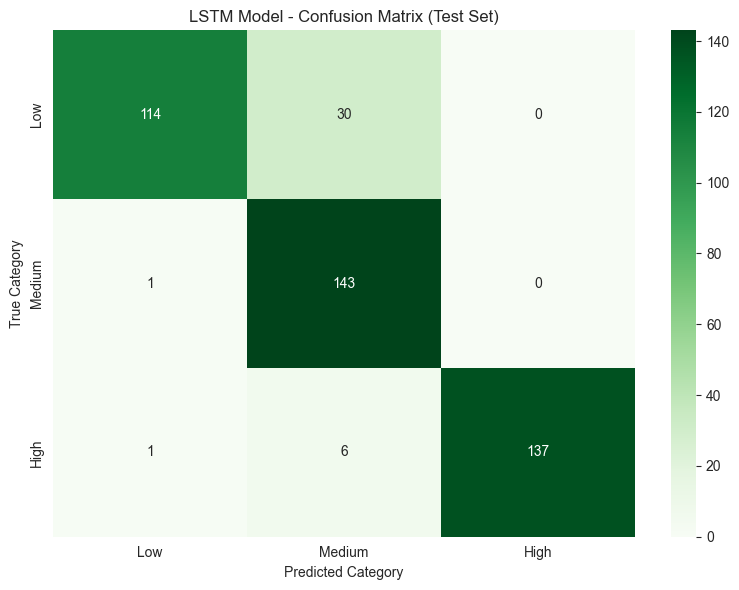


Detailed Classification Report (Test Set):
              precision    recall  f1-score   support

         Low       0.98      0.79      0.88       144
      Medium       0.80      0.99      0.89       144
        High       1.00      0.95      0.98       144

    accuracy                           0.91       432
   macro avg       0.93      0.91      0.91       432
weighted avg       0.93      0.91      0.91       432



In [20]:
# Confusion Matrix for LSTM
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
cm = confusion_matrix(lstm_class_test['y_true_cat'], lstm_class_test['y_pred_cat'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=ax,
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
ax.set_xlabel('Predicted Category')
ax.set_ylabel('True Category')
ax.set_title('LSTM Model - Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

print("\nDetailed Classification Report (Test Set):")
print(classification_report(lstm_class_test['y_true_cat'], lstm_class_test['y_pred_cat'],
                          target_names=['Low', 'Medium', 'High'], zero_division=0))

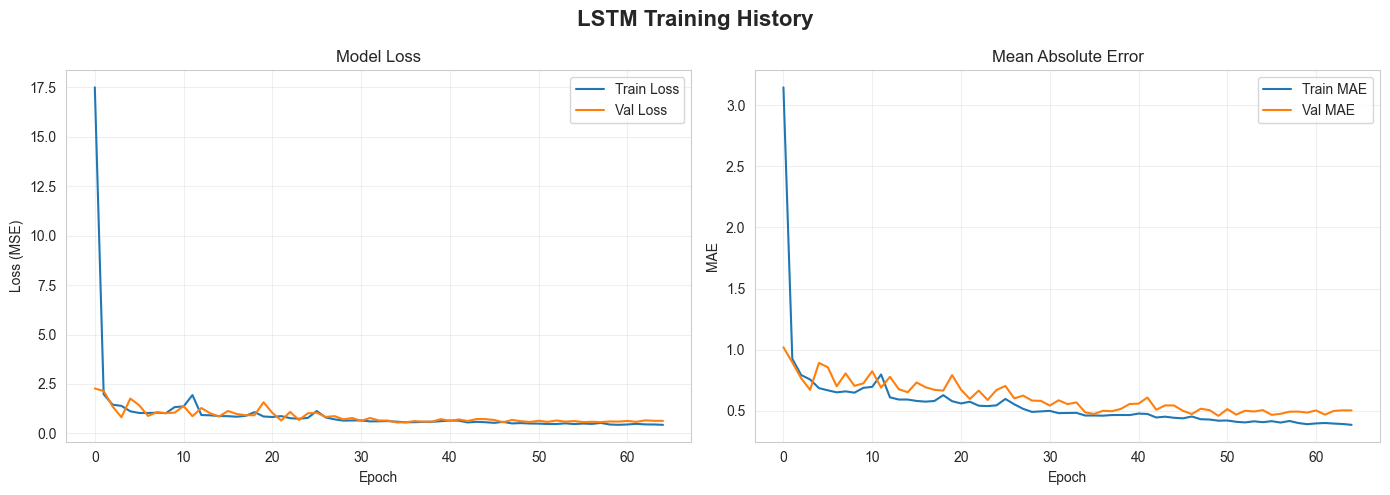

In [21]:
# Plot LSTM training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('LSTM Training History', fontsize=16, fontweight='bold')

# Loss
axes[0].plot(history_lstm.history['loss'], label='Train Loss')
axes[0].plot(history_lstm.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Model Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history_lstm.history['mae'], label='Train MAE')
axes[1].plot(history_lstm.history['val_mae'], label='Val MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Mean Absolute Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Part 3: Hybrid Model (LSTM + FNN)

### 3.1 Load Hybrid Data

In [22]:
print("\n📊 LOADING HYBRID DATA...")

# Load splits
hybrid_train = pd.read_csv(splits_path / 'hybrid' / 'train.csv')
hybrid_val = pd.read_csv(splits_path / 'hybrid' / 'val.csv')
hybrid_test = pd.read_csv(splits_path / 'hybrid' / 'test.csv')

print(f"  Train: {hybrid_train.shape}")
print(f"  Val:   {hybrid_val.shape}")
print(f"  Test:  {hybrid_test.shape}")

# Remove rows with missing yields
hybrid_train = hybrid_train.dropna(subset=['Yield_tonnes_per_ha'])
hybrid_val = hybrid_val.dropna(subset=['Yield_tonnes_per_ha'])
hybrid_test = hybrid_test.dropna(subset=['Yield_tonnes_per_ha'])

print(f"\nAfter removing missing yields:")
print(f"  Train: {hybrid_train.shape}")
print(f"  Val:   {hybrid_val.shape}")
print(f"  Test:  {hybrid_test.shape}")


📊 LOADING HYBRID DATA...
  Train: (34992, 41)
  Val:   (3888, 41)
  Test:  (5184, 41)

After removing missing yields:
  Train: (34992, 41)
  Val:   (3888, 41)
  Test:  (5184, 41)


### 3.2 Prepare Hybrid Features

In [23]:
# Temporal features (for LSTM branch)
hybrid_temporal_cols = [
    'Avg_Temp_C', 'Min_Temp_C', 'Max_Temp_C',
    'Rainfall_mm', 'Rainy_Days', 'Rainfall_Intensity',
    'Avg_Humidity_Percent',
    'CO2_ppm',
    'Heat_Stress_Days', 'Drought_Index', 'Flood_Risk_Index',
    'Is_Growing_Season'
]

# Static features (for FNN branch)
hybrid_static_cols = [
    'Soil_pH', 'Organic_Matter_Percent', 'Nitrogen_ppm', 'Phosphorus_ppm',
    'Potassium_ppm', 'Cation_Exchange_Capacity', 'Bulk_Density',
    'Water_Holding_Capacity_Percent'
]

# Encode categorical
hybrid_train['Crop_encoded'] = le_crop.transform(hybrid_train['Crop'])
hybrid_val['Crop_encoded'] = le_crop.transform(hybrid_val['Crop'])
hybrid_test['Crop_encoded'] = le_crop.transform(hybrid_test['Crop'])

hybrid_train['Zone_encoded'] = le_zone.transform(hybrid_train['Geopolitical_Zone'])
hybrid_val['Zone_encoded'] = le_zone.transform(hybrid_val['Geopolitical_Zone'])
hybrid_test['Zone_encoded'] = le_zone.transform(hybrid_test['Geopolitical_Zone'])

hybrid_static_cols.extend(['Crop_encoded', 'Zone_encoded'])

print(f"\nTemporal features: {len(hybrid_temporal_cols)}")
print(f"Static features: {len(hybrid_static_cols)}")


Temporal features: 12
Static features: 10


In [24]:
def create_hybrid_data(data, temporal_cols, static_cols, target_col, sequence_length=12):
    """
    Create hybrid data: temporal sequences + static features
    """
    X_temporal = []
    X_static = []
    y = []
    
    grouped = data.groupby(['Year', 'State', 'Crop'])
    
    for name, group in grouped:
        group = group.sort_values('Month')
        
        if len(group) >= sequence_length:
            # Temporal sequence
            temporal = group[temporal_cols].values[:sequence_length]
            X_temporal.append(temporal)
            
            # Static features (same for all months)
            static = group[static_cols].iloc[0].values
            X_static.append(static)
            
            # Target
            target = group[target_col].iloc[0]
            y.append(target)
    
    return np.array(X_temporal), np.array(X_static), np.array(y)

# Create hybrid datasets
print("\nCreating hybrid datasets...")
X_hybrid_temp_train, X_hybrid_stat_train, y_hybrid_train = create_hybrid_data(
    hybrid_train, hybrid_temporal_cols, hybrid_static_cols, target_col
)
X_hybrid_temp_val, X_hybrid_stat_val, y_hybrid_val = create_hybrid_data(
    hybrid_val, hybrid_temporal_cols, hybrid_static_cols, target_col
)
X_hybrid_temp_test, X_hybrid_stat_test, y_hybrid_test = create_hybrid_data(
    hybrid_test, hybrid_temporal_cols, hybrid_static_cols, target_col
)

print(f"\nHybrid data shapes:")
print(f"  Train - Temporal: {X_hybrid_temp_train.shape}, Static: {X_hybrid_stat_train.shape}")
print(f"  Val   - Temporal: {X_hybrid_temp_val.shape}, Static: {X_hybrid_stat_val.shape}")
print(f"  Test  - Temporal: {X_hybrid_temp_test.shape}, Static: {X_hybrid_stat_test.shape}")


Creating hybrid datasets...

Hybrid data shapes:
  Train - Temporal: (2916, 12, 12), Static: (2916, 10)
  Val   - Temporal: (324, 12, 12), Static: (324, 10)
  Test  - Temporal: (432, 12, 12), Static: (432, 10)


In [25]:
# Scale temporal features
hybrid_temp_scaler = StandardScaler()
n_train, seq_len, n_temp_features = X_hybrid_temp_train.shape
X_hybrid_temp_train_scaled = hybrid_temp_scaler.fit_transform(
    X_hybrid_temp_train.reshape(-1, n_temp_features)
).reshape(n_train, seq_len, n_temp_features)

n_val = X_hybrid_temp_val.shape[0]
X_hybrid_temp_val_scaled = hybrid_temp_scaler.transform(
    X_hybrid_temp_val.reshape(-1, n_temp_features)
).reshape(n_val, seq_len, n_temp_features)

n_test = X_hybrid_temp_test.shape[0]
X_hybrid_temp_test_scaled = hybrid_temp_scaler.transform(
    X_hybrid_temp_test.reshape(-1, n_temp_features)
).reshape(n_test, seq_len, n_temp_features)

# Scale static features
hybrid_stat_scaler = StandardScaler()
X_hybrid_stat_train_scaled = hybrid_stat_scaler.fit_transform(X_hybrid_stat_train)
X_hybrid_stat_val_scaled = hybrid_stat_scaler.transform(X_hybrid_stat_val)
X_hybrid_stat_test_scaled = hybrid_stat_scaler.transform(X_hybrid_stat_test)

print("\n✓ Hybrid features scaled")


✓ Hybrid features scaled


### 3.3 Build Hybrid Model

In [26]:
def build_hybrid_model(sequence_length, n_temporal_features, n_static_features, learning_rate=0.001):
    """
    Build Hybrid model combining LSTM and FNN
    """
    # LSTM branch (temporal)
    temporal_input = layers.Input(shape=(sequence_length, n_temporal_features), name='temporal_input')
    lstm_out = layers.LSTM(64, return_sequences=True)(temporal_input)
    lstm_out = layers.Dropout(0.3)(lstm_out)
    lstm_out = layers.LSTM(32, return_sequences=False)(lstm_out)
    lstm_out = layers.Dropout(0.2)(lstm_out)
    
    # FNN branch (static)
    static_input = layers.Input(shape=(n_static_features,), name='static_input')
    fnn_out = layers.Dense(32, activation='relu')(static_input)
    fnn_out = layers.BatchNormalization()(fnn_out)
    fnn_out = layers.Dropout(0.2)(fnn_out)
    
    # Merge branches
    merged = layers.concatenate([lstm_out, fnn_out])
    
    # Final layers
    dense_out = layers.Dense(32, activation='relu')(merged)
    dense_out = layers.BatchNormalization()(dense_out)
    dense_out = layers.Dropout(0.1)(dense_out)
    
    output = layers.Dense(1, activation='linear')(dense_out)
    
    # Create model
    model = models.Model(inputs=[temporal_input, static_input], outputs=output)
    
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='mse',
        metrics=['mae', tf.keras.metrics.RootMeanSquaredError(name='rmse')]
    )
    
    return model

# Build hybrid model
hybrid_model = build_hybrid_model(
    sequence_length=12,
    n_temporal_features=len(hybrid_temporal_cols),
    n_static_features=len(hybrid_static_cols)
)
hybrid_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ temporal_input      │ (None, 12, 12)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 12, 64)    │     19,712 │ temporal_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_input        │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 12, 64)    │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 32)        │        352 │ static_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 32)        │     12,416 │ dropout_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_6[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 32)        │          0 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ dropout_7[0][0],  │
│ (Concatenate)       │                   │            │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 32)        │      2,080 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32)        │        128 │ dense_7[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 32)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         33 │ dropout_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,849 (136.13 KB)

 Trainable params: 34,721 (135.63 KB)

 Non-trainable params: 128 (512.00 B)

### 3.4 Train Hybrid Model

In [27]:
# Define callbacks
early_stop_hybrid = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_hybrid = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=15,
    min_lr=1e-6,
    verbose=1
)

# Train hybrid model
print("\nTraining Hybrid model...")
history_hybrid = hybrid_model.fit(
    [X_hybrid_temp_train_scaled, X_hybrid_stat_train_scaled],
    y_hybrid_train,
    validation_data=([X_hybrid_temp_val_scaled, X_hybrid_stat_val_scaled], y_hybrid_val),
    epochs=200,
    batch_size=32,
    callbacks=[early_stop_hybrid, reduce_lr_hybrid],
    verbose=1
)

print("\n✓ Hybrid model training complete!")


Training Hybrid model...
Epoch 1/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - loss: 33.3548 - mae: 4.0817 - rmse: 5.7754 - val_loss: 23.2063 - val_mae: 3.4482 - val_rmse: 4.8173 - learning_rate: 0.0010
Epoch 2/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 23.7086 - mae: 3.4390 - rmse: 4.8691 - val_loss: 16.5784 - val_mae: 2.7850 - val_rmse: 4.0717 - learning_rate: 0.0010
Epoch 3/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 14.0139 - mae: 2.7659 - rmse: 3.7435 - val_loss: 9.6317 - val_mae: 2.2074 - val_rmse: 3.1035 - learning_rate: 0.0010
Epoch 4/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 8.9153 - mae: 2.2175 - rmse: 2.9858 - val_loss: 5.2573 - val_mae: 1.6322 - val_rmse: 2.2929 - learning_rate: 0.0010
Epoch 5/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.0999 - mae: 1.9792 - rmse: 2.6646 - val_loss: 3.5948 - val_mae: 1.3721 - val_rmse: 1.8960 - learning_rate: 0.0010
Epoch 6/200
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 5.5926 - mae: 1.7640 - rmse: 

### 3.5 Evaluate Hybrid Model

In [28]:
# Make predictions
y_hybrid_pred_train = hybrid_model.predict(
    [X_hybrid_temp_train_scaled, X_hybrid_stat_train_scaled]
).flatten()
y_hybrid_pred_val = hybrid_model.predict(
    [X_hybrid_temp_val_scaled, X_hybrid_stat_val_scaled]
).flatten()
y_hybrid_pred_test = hybrid_model.predict(
    [X_hybrid_temp_test_scaled, X_hybrid_stat_test_scaled]
).flatten()

print("\n" + "="*80)
print("HYBRID MODEL EVALUATION")
print("="*80)

hybrid_metrics_train = calculate_metrics(y_hybrid_train, y_hybrid_pred_train, "Train")
hybrid_metrics_val = calculate_metrics(y_hybrid_val, y_hybrid_pred_val, "Validation")
hybrid_metrics_test = calculate_metrics(y_hybrid_test, y_hybrid_pred_test, "Test")

# Calculate percentiles from training data
_, hybrid_percentiles = categorize_yield(y_hybrid_train)

hybrid_class_train = calculate_classification_metrics(y_hybrid_train, y_hybrid_pred_train, "Train", hybrid_percentiles)
hybrid_class_val = calculate_classification_metrics(y_hybrid_val, y_hybrid_pred_val, "Validation", hybrid_percentiles)
hybrid_class_test = calculate_classification_metrics(y_hybrid_test, y_hybrid_pred_test, "Test", hybrid_percentiles)

92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

HYBRID MODEL EVALUATION

Train Set - Regression Performance:
  RMSE:  0.4163 tonnes/ha
  MAE:   0.2990 tonnes/ha
  R²:    0.9905
  MAPE:  13.34%

Validation Set - Regression Performance:
  RMSE:  0.8557 tonnes/ha
  MAE:   0.6364 tonnes/ha
  R²:    0.9392
  MAPE:  20.23%

Test Set - Regression Performance:
  RMSE:  1.1339 tonnes/ha
  MAE:   0.8314 tonnes/ha
  R²:    0.8226
  MAPE:  26.52%

Train Set - Classification Performance:
  Accuracy:  0.7589
  Precision: 0.7882
  Recall:    0.7589
  F1-Score:  0.7435

Validation Set - Classification Performance:
  Accuracy:  0.7469
  Precision: 0.7511
  Recall:    0.7469
  F1-Score:  0.7438

Test Set - Classification Performance:
  Accuracy:  0.7593
  Precision: 0.7635
  Recall:    0.7593
  F1-Score:  0.7566


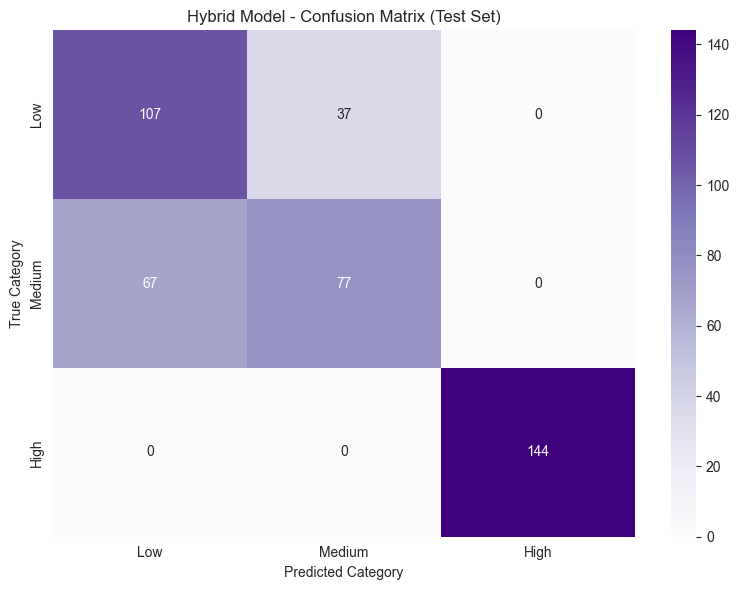


Detailed Classification Report (Test Set):
              precision    recall  f1-score   support

         Low       0.61      0.74      0.67       144
      Medium       0.68      0.53      0.60       144
        High       1.00      1.00      1.00       144

    accuracy                           0.76       432
   macro avg       0.76      0.76      0.76       432
weighted avg       0.76      0.76      0.76       432



In [29]:
# Confusion Matrix for Hybrid
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
cm = confusion_matrix(hybrid_class_test['y_true_cat'], hybrid_class_test['y_pred_cat'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', ax=ax,
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
ax.set_xlabel('Predicted Category')
ax.set_ylabel('True Category')
ax.set_title('Hybrid Model - Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

print("\nDetailed Classification Report (Test Set):")
print(classification_report(hybrid_class_test['y_true_cat'], hybrid_class_test['y_pred_cat'],
                          target_names=['Low', 'Medium', 'High'], zero_division=0))

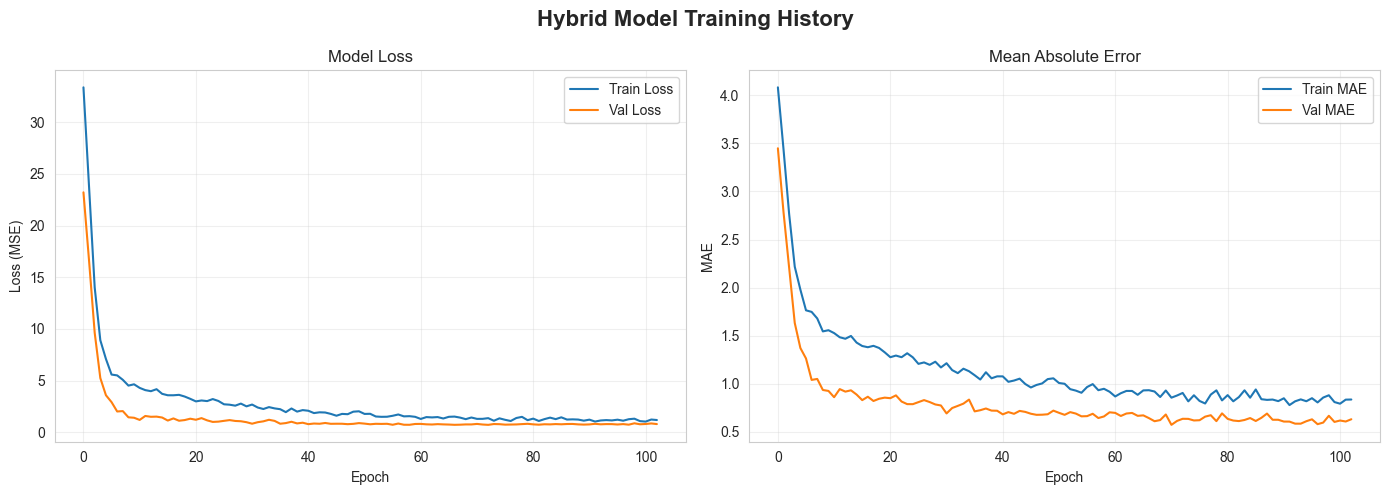

In [30]:
# Plot Hybrid training history
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Hybrid Model Training History', fontsize=16, fontweight='bold')

# Loss
axes[0].plot(history_hybrid.history['loss'], label='Train Loss')
axes[0].plot(history_hybrid.history['val_loss'], label='Val Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss (MSE)')
axes[0].set_title('Model Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# MAE
axes[1].plot(history_hybrid.history['mae'], label='Train MAE')
axes[1].plot(history_hybrid.history['val_mae'], label='Val MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].set_title('Mean Absolute Error')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---
## Part 4: Model Comparison

In [31]:
# Comprehensive comparison table
comparison_data = {
    'Model': ['FNN', 'LSTM', 'Hybrid'],
    
    # Regression metrics
    'Test RMSE': [
        fnn_metrics_test['RMSE'],
        lstm_metrics_test['RMSE'],
        hybrid_metrics_test['RMSE']
    ],
    'Test MAE': [
        fnn_metrics_test['MAE'],
        lstm_metrics_test['MAE'],
        hybrid_metrics_test['MAE']
    ],
    'Test R²': [
        fnn_metrics_test['R2'],
        lstm_metrics_test['R2'],
        hybrid_metrics_test['R2']
    ],
    'Test MAPE': [
        fnn_metrics_test['MAPE'],
        lstm_metrics_test['MAPE'],
        hybrid_metrics_test['MAPE']
    ],
    
    # Classification metrics
    'Test Accuracy': [
        fnn_class_test['Accuracy'],
        lstm_class_test['Accuracy'],
        hybrid_class_test['Accuracy']
    ],
    'Test Precision': [
        fnn_class_test['Precision'],
        lstm_class_test['Precision'],
        hybrid_class_test['Precision']
    ],
    'Test Recall': [
        fnn_class_test['Recall'],
        lstm_class_test['Recall'],
        hybrid_class_test['Recall']
    ],
    'Test F1-Score': [
        fnn_class_test['F1'],
        lstm_class_test['F1'],
        hybrid_class_test['F1']
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("MODEL COMPARISON (TEST SET) - REGRESSION METRICS")
print("="*80)
print(comparison_df[['Model', 'Test RMSE', 'Test MAE', 'Test R²', 'Test MAPE']].to_string(index=False))

print("\n" + "="*80)
print("MODEL COMPARISON (TEST SET) - CLASSIFICATION METRICS")
print("="*80)
print(comparison_df[['Model', 'Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1-Score']].to_string(index=False))

# Identify best model by different criteria
best_r2_idx = comparison_df['Test R²'].idxmax()
best_acc_idx = comparison_df['Test Accuracy'].idxmax()
best_f1_idx = comparison_df['Test F1-Score'].idxmax()

print("\n" + "="*80)
print("BEST MODELS BY METRIC")
print("="*80)
print(f"🏆 Best Regression (R²):     {comparison_df.loc[best_r2_idx, 'Model']} (R² = {comparison_df.loc[best_r2_idx, 'Test R²']:.4f})")
print(f"🎯 Best Classification (Acc): {comparison_df.loc[best_acc_idx, 'Model']} (Accuracy = {comparison_df.loc[best_acc_idx, 'Test Accuracy']:.4f})")
print(f"⚖️  Best F1-Score:            {comparison_df.loc[best_f1_idx, 'Model']} (F1 = {comparison_df.loc[best_f1_idx, 'Test F1-Score']:.4f})")


MODEL COMPARISON (TEST SET) - REGRESSION METRICS
 Model  Test RMSE  Test MAE   Test R²  Test MAPE
   FNN   2.732097  2.599711 -0.029802 134.125613
  LSTM   0.942633  0.541474  0.877412  17.009593
Hybrid   1.133919  0.831400  0.822611  26.519562

MODEL COMPARISON (TEST SET) - CLASSIFICATION METRICS
 Model  Test Accuracy  Test Precision  Test Recall  Test F1-Score
   FNN       0.333333        0.111111     0.333333       0.166667
  LSTM       0.912037        0.927214     0.912037       0.912487
Hybrid       0.759259        0.763460     0.759259       0.756618

BEST MODELS BY METRIC
🏆 Best Regression (R²):     LSTM (R² = 0.8774)
🎯 Best Classification (Acc): LSTM (Accuracy = 0.9120)
⚖️  Best F1-Score:            LSTM (F1 = 0.9125)


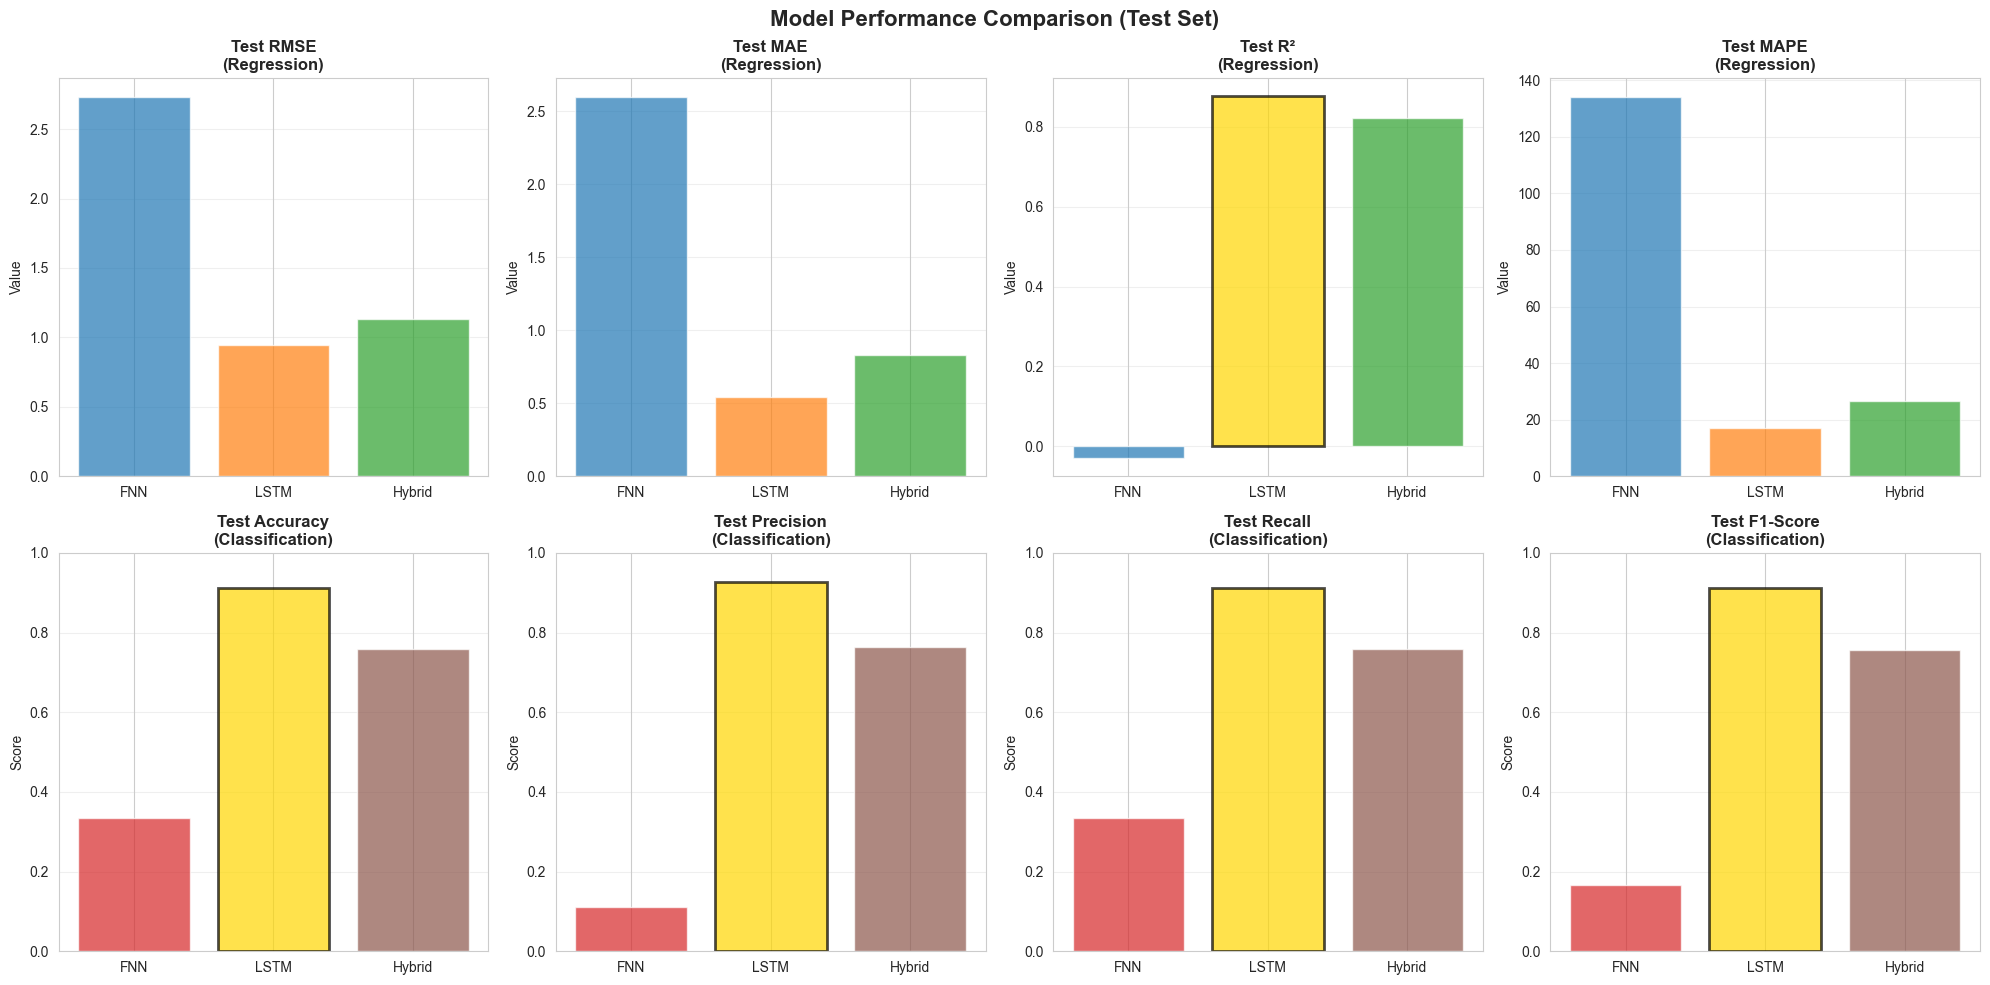

In [32]:
# Visualization: Model comparison
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Model Performance Comparison (Test Set)', fontsize=16, fontweight='bold')

# Regression metrics
reg_metrics = ['Test RMSE', 'Test MAE', 'Test R²', 'Test MAPE']
for idx, metric in enumerate(reg_metrics):
    ax = axes[0, idx]
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], alpha=0.7, color=['#1f77b4', '#ff7f0e', '#2ca02c'])
    ax.set_title(f'{metric}\n(Regression)', fontweight='bold')
    ax.set_ylabel('Value')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Highlight best
    if metric == 'Test R²':
        best_idx = comparison_df[metric].idxmax()
        bars[best_idx].set_color('gold')
        bars[best_idx].set_edgecolor('black')
        bars[best_idx].set_linewidth(2)

# Classification metrics
class_metrics = ['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1-Score']
for idx, metric in enumerate(class_metrics):
    ax = axes[1, idx]
    bars = ax.bar(comparison_df['Model'], comparison_df[metric], alpha=0.7, color=['#d62728', '#9467bd', '#8c564b'])
    ax.set_title(f'{metric}\n(Classification)', fontweight='bold')
    ax.set_ylabel('Score')
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Highlight best
    best_idx = comparison_df[metric].idxmax()
    bars[best_idx].set_color('gold')
    bars[best_idx].set_edgecolor('black')
    bars[best_idx].set_linewidth(2)

plt.tight_layout()
plt.show()

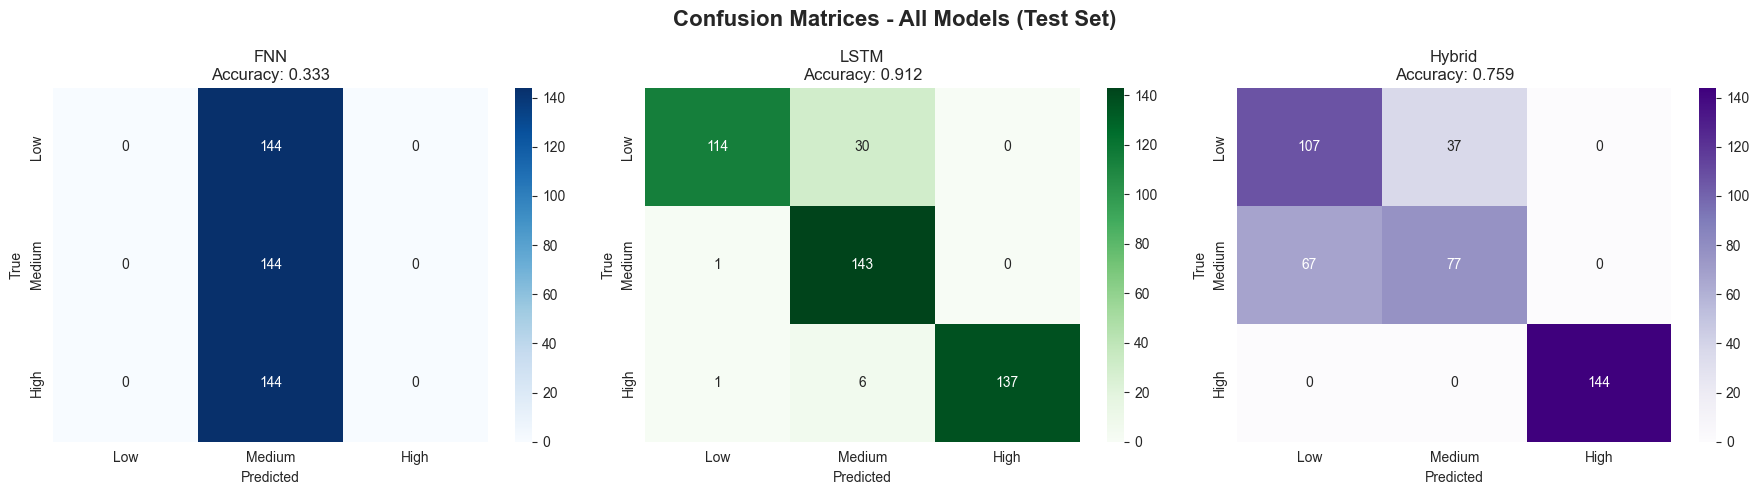

In [33]:
# Combined confusion matrices for all models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrices - All Models (Test Set)', fontsize=16, fontweight='bold')

models_data = [
    ('FNN', fnn_class_test, 'Blues'),
    ('LSTM', lstm_class_test, 'Greens'),
    ('Hybrid', hybrid_class_test, 'Purples')
]

for idx, (model_name, class_data, cmap) in enumerate(models_data):
    cm = confusion_matrix(class_data['y_true_cat'], class_data['y_pred_cat'])
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, ax=axes[idx],
                xticklabels=['Low', 'Medium', 'High'],
                yticklabels=['Low', 'Medium', 'High'])
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('True')
    axes[idx].set_title(f'{model_name}\nAccuracy: {class_data["Accuracy"]:.3f}')

plt.tight_layout()
plt.show()

---
## Part 5: Save Models

In [34]:
# Create models directory
models_path = Path('models')
models_path.mkdir(exist_ok=True)

# Save models
print("\nSaving models...")
fnn_model.save(models_path / 'fnn_model.keras')
lstm_model.save(models_path / 'lstm_model.keras')
hybrid_model.save(models_path / 'hybrid_model.keras')

# Save scalers and encoders
import joblib
joblib.dump(fnn_scaler, models_path / 'fnn_scaler.pkl')
joblib.dump(lstm_scaler, models_path / 'lstm_scaler.pkl')
joblib.dump(hybrid_temp_scaler, models_path / 'hybrid_temp_scaler.pkl')
joblib.dump(hybrid_stat_scaler, models_path / 'hybrid_stat_scaler.pkl')

# Save label encoders
joblib.dump(le_crop, models_path / 'le_crop.pkl')
joblib.dump(le_zone, models_path / 'le_zone.pkl')
joblib.dump(le_state, models_path / 'le_state.pkl')

print("\n✓ All models and preprocessors saved!")


Saving models...

✓ All models and preprocessors saved!


---
## Conclusion

This notebook successfully implemented and compared three deep learning architectures for crop yield prediction:

1. **FNN**: Uses annual aggregated features
2. **LSTM**: Captures monthly temporal patterns
3. **Hybrid**: Combines temporal sequences with static features

### Evaluation Approach

**Dual Evaluation Strategy:**
- **Regression Metrics** (RMSE, MAE, R², MAPE): For precise yield predictions in tonnes/ha
- **Classification Metrics** (Accuracy, Precision, Recall, F1): For categorizing yields as Low/Medium/High

This dual approach provides:
- Exact yield predictions for agricultural planning
- Easy-to-interpret performance categories for decision makers
- Comprehensive model assessment from multiple perspectives

All models have been trained, evaluated with both regression and classification metrics, and saved for future use.